In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import polars as pl
import glob
import re
import ast
from pathlib import Path
import numpy as np
from scipy.optimize import curve_fit

In [2]:
def procesar_y_expandir_logs(ruta_busqueda: str) -> pl.DataFrame:
    """
    Busca archivos de log, extrae información relevante y expande los
    hiperparámetros en columnas separadas dentro de un DataFrame de Polars.

    Args:
        ruta_busqueda (str): Patrón de búsqueda para glob (ej. 'logs/*.out').
    """
    lista_archivos = glob.glob(ruta_busqueda)

    if not lista_archivos:
        print(f"No se encontraron archivos con el patrón '{ruta_busqueda}'.")
        return pl.DataFrame()

    datos_extraidos = []

    # Expresiones regulares ajustadas
    regex = {
        'n_jobs': re.compile(r"N_JOBS=(\d+)"),
        'n_samples': re.compile(r"N_SAMPLES=(\d+)"),
        'slurm_cpus_per_task': re.compile(r"SLURM_CPUS_PER_TASK=(\d+)"),
        'inner_n_jobs': re.compile(r"inner_n_jobs=(\d+)"),
        'tiempo_total': re.compile(r"TIEMPO TOTAL ENTRENAMIENTO \(pared\): ([\d\.]+) s"),
        # --- REGEX MEJORADA: Busca específicamente un string que empieza con { y termina con } ---
        'params': re.compile(r"params=(\{.*\})"),
        'n_features': re.compile(r"N_FEATURES=(\d+)")
    }

    print(f"Procesando {len(lista_archivos)} archivo(s)...")

    for archivo_path in lista_archivos:
        path_obj = Path(archivo_path)
        with open(path_obj, 'r', encoding='utf-8') as f:
            contenido = f.read()

            # Diccionario base para esta fila de datos
            fila_datos = {
                'archivo': path_obj.name
            }

            # Extraer los datos básicos
            n_jobs = re.search(regex['n_jobs'], contenido)
            fila_datos['n_jobs'] = int(n_jobs.group(1)) if n_jobs else None

            n_samples = re.search(regex['n_samples'], contenido)
            fila_datos['n_samples'] = int(n_samples.group(1)) if n_samples else None

            slurm_cpus = re.search(regex['slurm_cpus_per_task'], contenido)
            fila_datos['slurm_cpus_per_task'] = int(slurm_cpus.group(1)) if slurm_cpus else None

            inner_n_jobs = re.search(regex['inner_n_jobs'], contenido)
            fila_datos['inner_n_jobs'] = int(inner_n_jobs.group(1)) if inner_n_jobs else None

            tiempo = re.search(regex['tiempo_total'], contenido)
            fila_datos['tiempo_total_entrenamiento'] = float(tiempo.group(1)) if tiempo else None

            n_features = re.search(regex['n_features'], contenido)
            fila_datos['n_features'] = int(n_features.group(1)) if n_features else None

            # --- LÓGICA MEJORADA PARA PARSEAR Y EXPANDIR PARÁMETROS ---
            params_match = re.search(regex['params'], contenido)
            if params_match:
                # Obtenemos el string del diccionario capturado por el grupo 1
                params_string_limpio = params_match.group(1).strip()
                try:
                    # Parseamos el string a un diccionario de Python
                    params_dict = ast.literal_eval(params_string_limpio)
                    # Actualizamos el diccionario de la fila con los parámetros
                    fila_datos.update(params_dict)
                except (ValueError, SyntaxError):
                    print(f"Advertencia: No se pudieron parsear los parámetros en el archivo {path_obj.name}")
                    # Para depuración, imprime el string que falló
                    print(f"   ---> String problemático: '{params_string_limpio}'")

            datos_extraidos.append(fila_datos)

    # Polars creará automáticamente las columnas para todas las claves encontradas,
    # rellenando con 'null' los valores faltantes en cada fila.
    if not datos_extraidos:
        return pl.DataFrame()

    df = pl.DataFrame(datos_extraidos)
    return df

In [3]:
base_path = Path('logs/run_01')
file_glob = 'rnn_rnn_joblib_*.out'
df_resultados = procesar_y_expandir_logs(ruta_busqueda=base_path.joinpath(file_glob).as_posix())

Procesando 24 archivo(s)...


In [4]:
df_resultados

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,n_features,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init
str,i64,i64,i64,i64,f64,null,f64,list[i64],f64
"""rnn_rnn_joblib_14799_5.out""",32,40000,32,1,38.004,null,0.0001,[64],0.001
"""rnn_rnn_joblib_14799_4.out""",16,40000,32,1,38.454,null,0.0001,[64],0.001
"""rnn_rnn_joblib_14799_3.out""",8,40000,32,1,61.765,null,0.0001,[64],0.001
"""rnn_rnn_joblib_14799_2.out""",4,40000,32,1,104.195,null,0.0001,[64],0.001
"""rnn_rnn_joblib_14799_1.out""",2,40000,32,1,194.007,null,0.0001,[64],0.001
…,…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_14794_4.out""",16,5000,32,1,6.393,null,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_3.out""",8,5000,32,1,9.721,null,0.0001,[64],0.001
"""rnn_rnn_joblib_14794_2.out""",4,5000,32,1,15.523,null,0.0001,[64],0.001


In [5]:
df_resultados_measures = df_resultados.with_columns(
    pl.col('tiempo_total_entrenamiento').filter(pl.col('n_jobs') == 1).first().over('n_samples').alias(
        'numerador_speedup')).with_columns(
    speedup=pl.col('numerador_speedup') / pl.col('tiempo_total_entrenamiento')).with_columns(
    efficiency=pl.col('speedup') / pl.col('n_jobs'),speedup_pct_change=pl.col('speedup').pct_change().over('n_samples',order_by='n_jobs')).sort(by=['n_samples','n_jobs'])

In [6]:
df_resultados_measures

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,n_features,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init,numerador_speedup,speedup,efficiency,speedup_pct_change
str,i64,i64,i64,i64,f64,null,f64,list[i64],f64,f64,f64,f64,f64
"""rnn_rnn_joblib_14794_0.out""",1,5000,32,1,53.157,null,0.0001,[64],0.001,53.157,1.0,1.0,null
"""rnn_rnn_joblib_14794_1.out""",2,5000,32,1,28.888,null,0.0001,[64],0.001,53.157,1.840107,0.920053,0.840107
"""rnn_rnn_joblib_14794_2.out""",4,5000,32,1,15.523,null,0.0001,[64],0.001,53.157,3.424402,0.856101,0.86098
"""rnn_rnn_joblib_14794_3.out""",8,5000,32,1,9.721,null,0.0001,[64],0.001,53.157,5.468265,0.683533,0.596852
"""rnn_rnn_joblib_14794_4.out""",16,5000,32,1,6.393,null,0.0001,[64],0.001,53.157,8.314876,0.51968,0.520569
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_14799_1.out""",2,40000,32,1,194.007,null,0.0001,[64],0.001,380.896,1.963311,0.981655,0.963311
"""rnn_rnn_joblib_14799_2.out""",4,40000,32,1,104.195,null,0.0001,[64],0.001,380.896,3.655607,0.913902,0.861961
"""rnn_rnn_joblib_14799_3.out""",8,40000,32,1,61.765,null,0.0001,[64],0.001,380.896,6.166858,0.770857,0.686959


In [7]:
df_grafico=df_resultados_measures

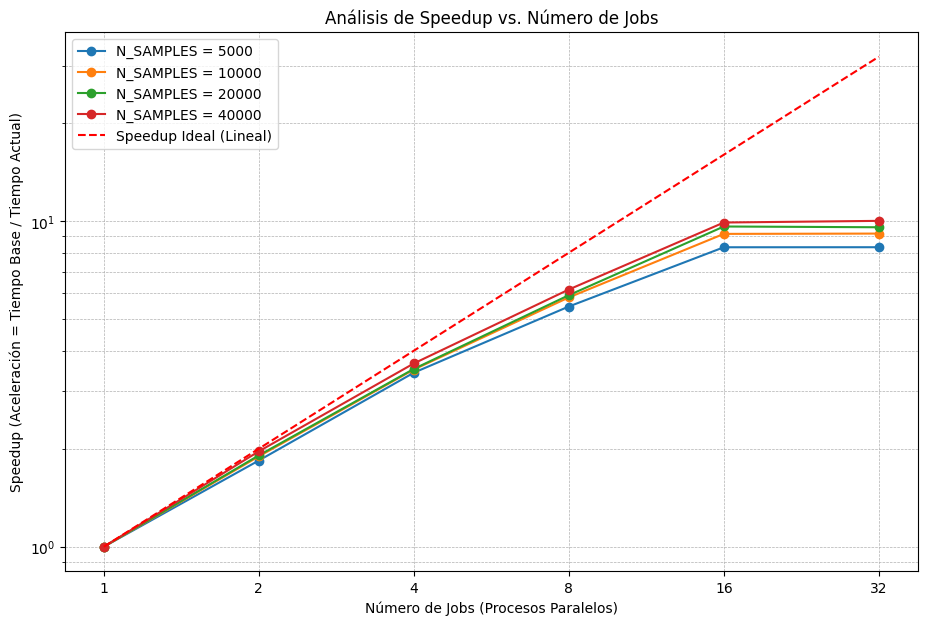

In [8]:
plt.figure(figsize=(11, 7))

# 3. Obtenemos los valores únicos de n_samples para crear una línea por cada uno
valores_n_samples = df_grafico.get_column("n_samples").unique().sort()

# 4. Iteramos sobre cada valor de n_samples y ploteamos su línea
for n_samp in valores_n_samples:
    # Filtramos el DataFrame para obtener solo los datos de este n_samples
    subset = df_grafico.filter(pl.col("n_samples") == n_samp)

    plt.plot(
        subset.get_column("n_jobs"),       # Eje X
        subset.get_column("speedup"),      # Eje Y
        marker='o',                        # Poner un círculo en cada punto de dato
        linestyle='-',                     # Unir los puntos con una línea
        label=f'N_SAMPLES = {n_samp}'    # Etiqueta para la leyenda
    )

# --- ESTILIZACIÓN DE LA GRÁFICA (adaptado de tu ejemplo) ---

# 5. Añadimos una línea de "Speedup Ideal" para comparar
# El speedup ideal es lineal (si duplicas los procesadores, duplicas la velocidad)
todos_los_n_jobs = df_grafico.get_column("n_jobs").unique().sort()
plt.plot(
    todos_los_n_jobs,
    todos_los_n_jobs,
    linestyle='--',
    color='red',
    label='Speedup Ideal (Lineal)'
)

# 6. Configuramos etiquetas y título
plt.xlabel("Número de Jobs (Procesos Paralelos)")
plt.ylabel("Speedup (Aceleración = Tiempo Base / Tiempo Actual)")
plt.title("Análisis de Speedup vs. Número de Jobs")

# 7. Configuramos el eje X en escala logarítmica base 2
# Esto es ideal cuando tus jobs son potencias de 2 (1, 2, 4, 8...)
plt.xscale("log", base=2)
plt.yscale("log")
plt.xticks(todos_los_n_jobs, todos_los_n_jobs) # Mostramos los ticks en el eje X

# 8. Añadimos leyenda y cuadrícula
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

# 9. Mostramos la gráfica
plt.show()

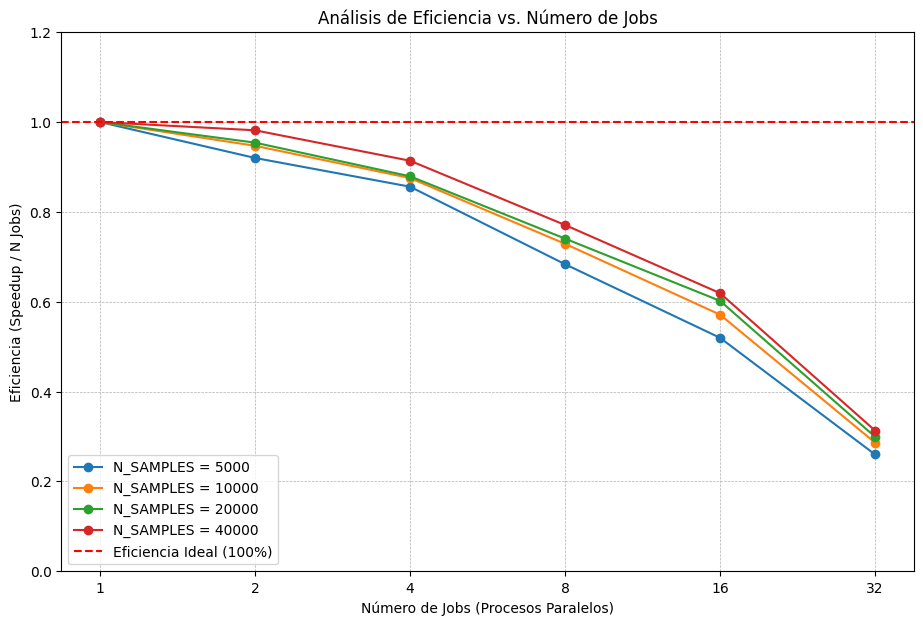

In [9]:
plt.figure(figsize=(11, 7))

# 3. Obtenemos los valores únicos de n_samples
valores_n_samples = df_grafico.get_column("n_samples").unique().sort()

# 4. Iteramos sobre cada valor y ploteamos su línea
for n_samp in valores_n_samples:
    subset = df_grafico.filter(pl.col("n_samples") == n_samp)

    plt.plot(
        subset.get_column("n_jobs"),
        subset.get_column("efficiency"),  # <-- CAMBIO AQUÍ
        marker='o',
        linestyle='-',
        label=f'N_SAMPLES = {n_samp}'
    )

# --- ESTILIZACIÓN DE LA GRÁFICA ---

# 5. Añadimos una línea de "Eficiencia Ideal" (un valor constante de 1.0)
plt.axhline(y=1.0, linestyle='--', color='red', label='Eficiencia Ideal (100%)')

# 6. Configuramos etiquetas y título
plt.xlabel("Número de Jobs (Procesos Paralelos)")
plt.ylabel("Eficiencia (Speedup / N Jobs)")
plt.title("Análisis de Eficiencia vs. Número de Jobs")

# 7. Configuramos el eje X en escala logarítmica base 2
todos_los_n_jobs = df_grafico.get_column("n_jobs").unique().sort()
plt.xscale("log", base=2)
plt.xticks(todos_los_n_jobs, todos_los_n_jobs)

# Opcional: ajustar los límites del eje Y para enfocarse entre 0 y 1.2
plt.ylim(0, 1.2)

# 8. Añadimos leyenda y cuadrícula
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

# 9. Mostramos la gráfica
plt.show()

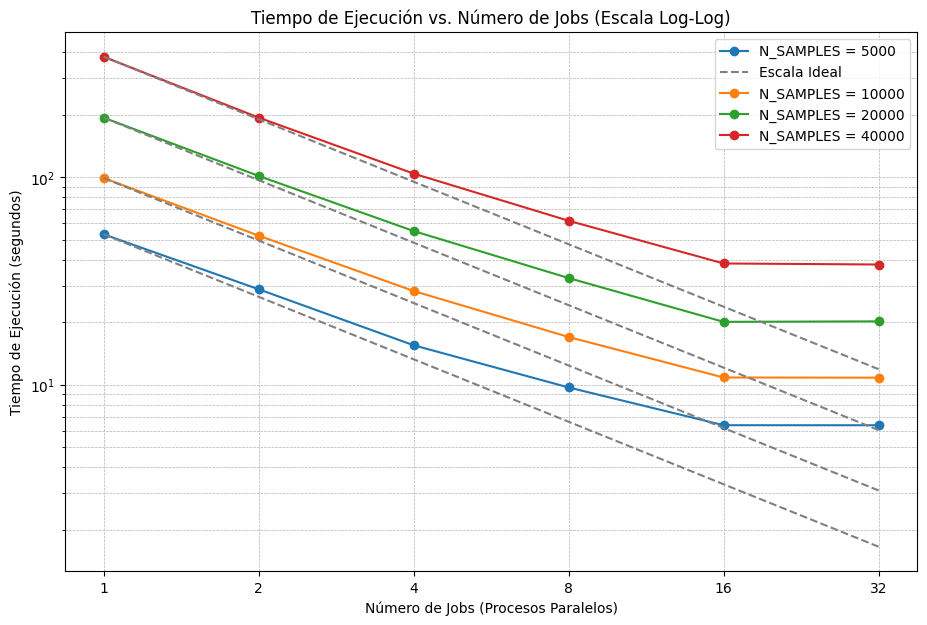

In [10]:
# Asumo que tu DataFrame final se llama 'df_resultados_measures'
# df_resultados_measures = ... (tu código de cálculo)

# --- INICIO DEL CÓDIGO PARA GRAFICAR TIEMPO DE EJECUCIÓN ---

# 1. Ordenamos los datos
df_grafico = df_resultados_measures.sort(["n_samples", "n_jobs"])

# 2. Creamos la figura y los ejes
plt.figure(figsize=(11, 7))

# 3. Obtenemos los valores únicos de n_samples
valores_n_samples = df_grafico.get_column("n_samples").unique().sort()
todos_los_n_jobs = df_grafico.get_column("n_jobs").unique().sort().to_numpy() # Convertir a array de numpy

# 4. Iteramos sobre cada valor y ploteamos su línea
for n_samp in valores_n_samples:
    subset = df_grafico.filter(pl.col("n_samples") == n_samp)

    # Ploteamos el tiempo observado
    plt.plot(
        subset.get_column("n_jobs"),
        subset.get_column("tiempo_total_entrenamiento"), # <-- CAMBIO AQUÍ
        marker='o',
        linestyle='-',
        label=f'N_SAMPLES = {n_samp}'
    )

    # Calculamos y ploteamos la "escala perfecta" para este grupo
    # Tiempo_ideal(N) = Tiempo(1) / N
    tiempo_base = subset.get_column("numerador_speedup")[0] # El tiempo con n_jobs=1
    tiempo_ideal = tiempo_base / todos_los_n_jobs

    plt.plot(
        todos_los_n_jobs,
        tiempo_ideal,
        linestyle='--',
        color='grey',
        label=f'Escala Ideal' if n_samp == valores_n_samples[0] else ""
    )

# --- ESTILIZACIÓN DE LA GRÁFICA ---

# 5. Configuramos etiquetas y título
plt.xlabel("Número de Jobs (Procesos Paralelos)")
plt.ylabel("Tiempo de Ejecución (segundos)")
plt.title("Tiempo de Ejecución vs. Número de Jobs (Escala Log-Log)")

# 6. Configuramos AMBOS ejes en escala logarítmica
plt.xscale("log", base=2)
plt.yscale("log") # <-- Eje Y también logarítmico
plt.xticks(todos_los_n_jobs, todos_los_n_jobs)

# 7. Añadimos leyenda y cuadrícula
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)

# 8. Mostramos la gráfica
plt.show()

Modelo ajustado para N=40000:
  Componente Secuencial (C_s): -4.336 s
  Componente Paralelizable (C_p): 385.411 s
  Componente de Overhead (C_o): 5.637 s


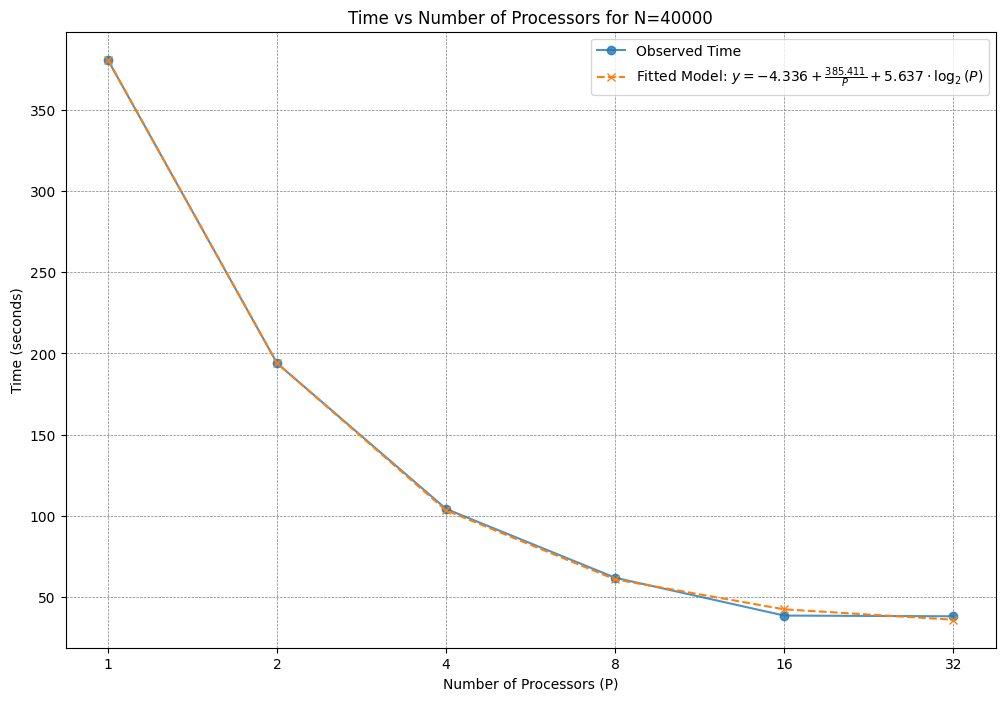

In [11]:
N_SAMPLES_TO_ANALYZE = 40000  # <--- CAMBIA ESTE VALOR (e.g., por 5000, 20000, 40000)

# Filtra el DataFrame para obtener los datos de un solo experimento
df_single_n = df_resultados_measures.filter(
    pl.col("n_samples") == N_SAMPLES_TO_ANALYZE
).sort("n_jobs")

# Si no hay datos para ese n_samples, detenemos la ejecución
if df_single_n.is_empty():
    print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE}. Por favor, elige otro valor.")
else:
    # 2. Extrae los datos a arrays de NumPy para usarlos con SciPy
    P = df_single_n.get_column("n_jobs").to_numpy()
    T_observed = df_single_n.get_column("tiempo_total_entrenamiento").to_numpy()

    # 3. Define la función del modelo teórico que queremos ajustar
    def theoretical_time_model(p, C_s, C_p, C_o):
        """
        Modelo de tiempo de ejecución con overhead.
        p: número de procesadores (n_jobs)
        C_s: componente de tiempo secuencial
        C_p: componente de tiempo paralelizable (para p=1)
        C_o: componente de sobrecarga (overhead)
        """
        # np.log2(1) es 0, por lo que el término de overhead desaparece para el caso base.
        return C_s + (C_p / p) + (C_o * np.log2(p))

    # 4. Usa scipy.optimize.curve_fit para encontrar los mejores parámetros
    try:
        # P_opt contendrá los valores óptimos para (C_s, C_p, C_o)
        p_opt, _ = curve_fit(theoretical_time_model, P, T_observed)
        C_s_fit, C_p_fit, C_o_fit = p_opt

        # Calcula los valores del tiempo predicho por el modelo ajustado
        T_fitted = theoretical_time_model(P, C_s_fit, C_p_fit, C_o_fit)

        print(f"Modelo ajustado para N={N_SAMPLES_TO_ANALYZE}:")
        print(f"  Componente Secuencial (C_s): {C_s_fit:.3f} s")
        print(f"  Componente Paralelizable (C_p): {C_p_fit:.3f} s")
        print(f"  Componente de Overhead (C_o): {C_o_fit:.3f} s")

        fit_successful = True
    except RuntimeError:
        print("El ajuste del modelo falló. Se graficarán solo los datos observados.")
        fit_successful = False


    # 5. Grafica los resultados
    # Para replicar el estilo oscuro del ejemplo:
    plt.style.use('default')

    plt.figure(figsize=(12, 8))

    # Plotea los datos medidos
    plt.plot(P, T_observed, marker='o', linestyle='-', label='Observed Time', alpha=0.8)

    # Si el ajuste fue exitoso, plotea el modelo
    if fit_successful:
        legend_label = (
        f'Fitted Model: $y = {C_s_fit:.3f} + \\frac{{{C_p_fit:.3f}}}{{P}} + {C_o_fit:.3f} \\cdot \\log_{{2}}(P)$'
        )
        plt.plot(P, T_fitted, marker='x', linestyle='--', label=legend_label)

    # --- ESTILIZACIÓN DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Time (seconds)")
    plt.title(f"Time vs Number of Processors for N={N_SAMPLES_TO_ANALYZE}")

    plt.xscale("log", base=2)
    plt.xticks(P, P) # Asegura que los ticks del eje X sean 1, 2, 4, 8...

    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

Modelo ajustado para N=40000:
  Componente Secuencial (C_s): -5.103 s
  Componente Paralelizable (C_p): 654.787 s
  Componente de Overhead (C_o): 8.708 s


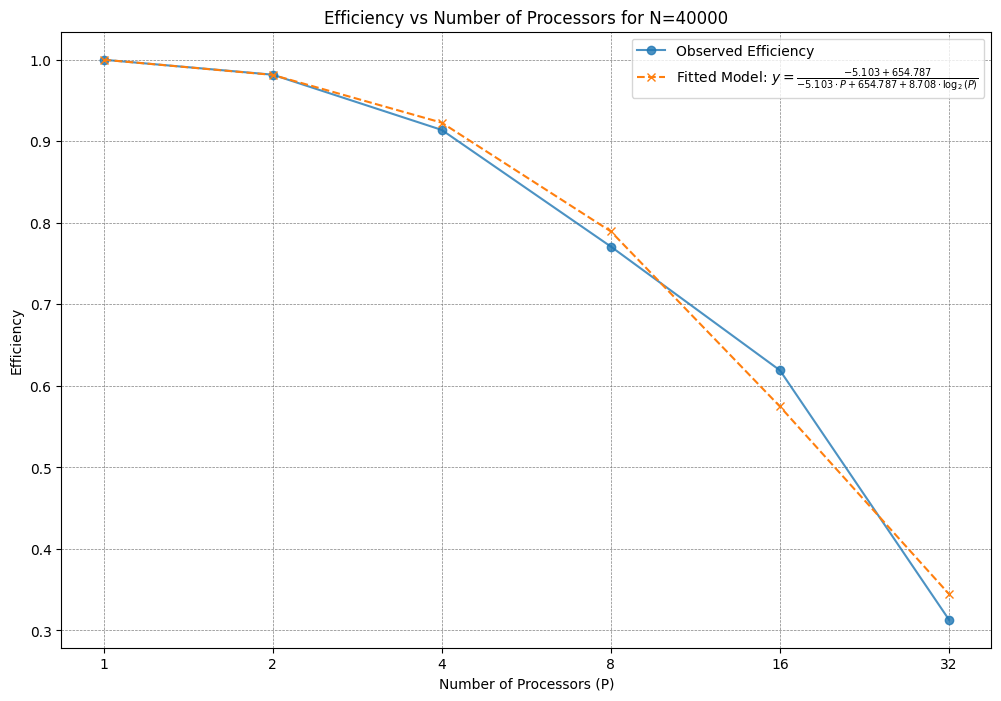

In [12]:
N_SAMPLES_TO_ANALYZE = 40000  # <--- CAMBIA ESTE VALOR (e.g., por 5000, 20000, 40000)

# Filtra el DataFrame para obtener los datos de un solo experimento
df_single_n = df_resultados_measures.filter(
    pl.col("n_samples") == N_SAMPLES_TO_ANALYZE
).sort("n_jobs")

# Si no hay datos para ese n_samples, detenemos la ejecución
if df_single_n.is_empty():
    print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE}. Por favor, elige otro valor.")
else:
    # 2. Extrae los datos a arrays de NumPy para usarlos con SciPy
    P = df_single_n.get_column("n_jobs").to_numpy()
    E_observed = df_single_n.get_column("efficiency").to_numpy()

    # 3. Define la función del modelo teórico que queremos ajustar
    def theoretical_efficiency_model(p, C_s, C_p, C_o):
        """
        Modelo de tiempo de ejecución con overhead.
        p: número de procesadores (n_jobs)
        C_s: componente de tiempo secuencial
        C_p: componente de tiempo paralelizable (para p=1)
        C_o: componente de sobrecarga (overhead)
        """
        # np.log2(1) es 0, por lo que el término de overhead desaparece para el caso base.
        return (C_s + C_p) / (p*C_s + C_p + p*C_o*np.log2(p))

    # 4. Usa scipy.optimize.curve_fit para encontrar los mejores parámetros
    try:
        # P_opt contendrá los valores óptimos para (C_s, C_p, C_o)
        p_opt, _ = curve_fit(theoretical_efficiency_model, P, E_observed)
        C_s_fit, C_p_fit, C_o_fit = p_opt

        # Calcula los valores del tiempo predicho por el modelo ajustado
        E_fitted = theoretical_efficiency_model(P, C_s_fit, C_p_fit, C_o_fit)

        print(f"Modelo ajustado para N={N_SAMPLES_TO_ANALYZE}:")
        print(f"  Componente Secuencial (C_s): {C_s_fit:.3f} s")
        print(f"  Componente Paralelizable (C_p): {C_p_fit:.3f} s")
        print(f"  Componente de Overhead (C_o): {C_o_fit:.3f} s")

        fit_successful = True
    except RuntimeError:
        print("El ajuste del modelo falló. Se graficarán solo los datos observados.")
        fit_successful = False


    # 5. Grafica los resultados
    # Para replicar el estilo oscuro del ejemplo:
    plt.style.use('default')

    plt.figure(figsize=(12, 8))

    # Plotea los datos medidos
    plt.plot(P, E_observed, marker='o', linestyle='-', label='Observed Efficiency', alpha=0.8)

#(C_s + C_p) / (p*C_s + C_p + p*C_o*np.log2(p))
    
    # Si el ajuste fue exitoso, plotea el modelo
    if fit_successful:
        legend_label = (
        f'Fitted Model: $y = \\frac{{{C_s_fit:.3f}+{C_p_fit:.3f}}} {{{C_s_fit:.3f}\\cdot P+  {C_p_fit:.3f}+ {C_o_fit:.3f} \\cdot \\log_{{2}}(P)}}$'
        )
        plt.plot(P, E_fitted, marker='x', linestyle='--', label=legend_label)

    # --- ESTILIZACIÓN DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Efficiency")
    plt.title(f"Efficiency vs Number of Processors for N={N_SAMPLES_TO_ANALYZE}")

    plt.xscale("log", base=2)
    plt.xticks(P, P) # Asegura que los ticks del eje X sean 1, 2, 4, 8...

    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

In [13]:
base_path_ex5 = Path('logs/run_ex5')
file_glob_ex5 = 'rnn_rnn_joblib_ex5_1*.out'
df_resultados_ex5 = procesar_y_expandir_logs(ruta_busqueda=base_path_ex5.joinpath(file_glob_ex5).as_posix()).filter(pl.col('tiempo_total_entrenamiento').is_not_null())
df_resultados_ex5_measures = df_resultados_ex5.with_columns(
    pl.col('tiempo_total_entrenamiento').filter(pl.col('n_jobs') == 1).first().over('n_samples', 'mlpclassifier__hidden_layer_sizes','n_features').alias(
        'numerador_speedup')).with_columns(
    speedup=pl.col('numerador_speedup') / pl.col('tiempo_total_entrenamiento')).with_columns(
    efficiency=pl.col('speedup') / pl.col('n_jobs'),speedup_pct_change=pl.col('speedup').pct_change().over('n_samples',order_by='n_jobs')).sort(by=['n_samples','n_jobs'])

Procesando 67 archivo(s)...


In [14]:
df_resultados_ex5_measures

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,n_features,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init,numerador_speedup,speedup,efficiency,speedup_pct_change
str,i64,i64,i64,i64,f64,i64,f64,list[i64],f64,f64,f64,f64,f64
"""rnn_rnn_joblib_ex5_16658_24.ou…",1,5000,32,1,213.273,128,0.0001,[256],0.001,213.273,1.0,1.0,0.0
"""rnn_rnn_joblib_ex5_16658_0.out""",1,5000,32,1,193.095,64,0.0001,[256],0.001,193.095,1.0,1.0,null
"""rnn_rnn_joblib_ex5_16658_1.out""",2,5000,32,1,97.838,64,0.0001,[256],0.001,193.095,1.97362,0.98681,0.97362
"""rnn_rnn_joblib_ex5_16658_25.ou…",2,5000,32,1,110.066,128,0.0001,[256],0.001,213.273,1.937683,0.968841,-0.018209
"""rnn_rnn_joblib_ex5_16658_2.out""",4,5000,32,1,53.212,64,0.0001,[256],0.001,193.095,3.628787,0.907197,0.872745
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_ex5_16658_19.ou…",2,200000,32,1,5316.705,64,0.0001,[256],0.001,10063.591,1.892825,0.946412,0.892825
"""rnn_rnn_joblib_ex5_16658_20.ou…",4,200000,32,1,2784.868,64,0.0001,[256],0.001,10063.591,3.613669,0.903417,0.909141
"""rnn_rnn_joblib_ex5_16658_21.ou…",8,200000,32,1,1682.646,64,0.0001,[256],0.001,10063.591,5.980813,0.747602,0.655053


In [15]:
def plot_efficiency_model_divided_features(df_resultados_ex5_measures, N_SAMPLES_TO_ANALYZE, MLP_CLASSIFIER_VALUE):
    """
    Filtra los datos por un n_samples y un mlpclassifier específicos, y luego grafica
    y modela las curvas de eficiencia para cada grupo de n_features encontrado.

    Args:
        df_resultados_ex5_measures (pl.DataFrame): El DataFrame con los resultados.
        N_SAMPLES_TO_ANALYZE (int): El número de muestras a filtrar.
        MLP_CLASSIFIER_VALUE: El valor específico en la columna 'mlpclassifier' para filtrar.
                               (Puede ser un string como '[64]' o un int como 64,
                               dependiendo del tipo de dato en tu DataFrame).
    """
    # 1. Filtra el DataFrame por N_SAMPLES y el MLP_CLASSIFIER_VALUE especificado
    df_filtered = df_resultados_ex5_measures.filter(
        (pl.col("n_samples") == N_SAMPLES_TO_ANALYZE) &
        (pl.col("mlpclassifier__hidden_layer_sizes") == MLP_CLASSIFIER_VALUE)
    )

    if df_filtered.is_empty():
        print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE} y mlpclassifier = '{MLP_CLASSIFIER_VALUE}'.")
        print("Por favor, verifica los valores y el tipo de dato.")
        return

    # 2. Obtiene los valores únicos de la columna 'n_features' para agrupar
    n_features_groups = df_filtered.get_column("n_features").unique().sort().to_list()

    if not n_features_groups:
        print("No se encontraron grupos de 'n_features' para los filtros aplicados.")
        return

    # --- INICIO DE LA GRÁFICA ---
    plt.style.use('default')
    plt.figure(figsize=(14, 9))

    colors = plt.cm.viridis(np.linspace(0, 1, len(n_features_groups)))

    # 3. Define la función del modelo teórico (una sola vez)
    def theoretical_efficiency_model(p, C_s, C_p, C_o):
        """ Modelo de eficiencia con overhead. """
        # np.log2(p) puede dar -inf si p=0, aunque aquí P siempre será >= 1.
        # Se añade un pequeño epsilon por seguridad en casos generales.
        return (C_s + C_p) / (p * C_s + C_p + p * C_o * np.log2(p + 1e-9))

    # 4. Itera sobre cada grupo de n_features para modelar y graficar
    for i, current_n_features in enumerate(n_features_groups):

        # Filtra los datos para el grupo de n_features actual
        df_single_group = df_filtered.filter(
            pl.col('n_features') == current_n_features
        ).sort("n_jobs")

        if df_single_group.is_empty():
            continue

        # Extrae los datos a arrays de NumPy
        P = df_single_group.get_column("n_jobs").to_numpy()
        E_observed = df_single_group.get_column("efficiency").to_numpy()

        # Plotea los datos medidos para este grupo
        plt.plot(P, E_observed, marker='o', linestyle='-', label=f'Observed ({current_n_features} features)', color=colors[i], alpha=0.8)

        # Ajusta el modelo teórico
        try:
            # Proporcionar valores iniciales (p0) puede ayudar a la convergencia
            p_opt, _ = curve_fit(theoretical_efficiency_model, P, E_observed, p0=[0.1, 1, 0.01], maxfev=5000)
            C_s_fit, C_p_fit, C_o_fit = p_opt

            E_fitted = theoretical_efficiency_model(P, C_s_fit, C_p_fit, C_o_fit)

            print(f"--- Modelo para n_features={current_n_features} ---")
            print(f"  (N_SAMPLES={N_SAMPLES_TO_ANALYZE}, mlpclassifier='{MLP_CLASSIFIER_VALUE}')")
            print(f"  Componente Secuencial (C_s): {C_s_fit:.4f}")
            print(f"  Componente Paralelizable (C_p): {C_p_fit:.4f}")
            print(f"  Componente de Overhead (C_o): {C_o_fit:.4f}\n")

            # Plotea la curva del modelo ajustado
            plt.plot(P, E_fitted, marker='x', linestyle='--', label=f'Fitted Model ({current_n_features} features)', color=colors[i])

        except RuntimeError:
            print(f"El ajuste del modelo falló para n_features={current_n_features}. Se graficarán solo los datos observados.\n")

    # --- ESTILIZACIÓN FINAL DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Efficiency")
    plt.title(f"Efficiency vs. Processors for N={N_SAMPLES_TO_ANALYZE} (Classifier: {MLP_CLASSIFIER_VALUE})")

    plt.xscale("log", base=2)
    all_p_values = df_filtered.get_column("n_jobs").unique().sort().to_list()
    plt.xticks(all_p_values, all_p_values)

    plt.legend(title="Feature Groups")
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

In [16]:
def plot_efficiency_model_divided_MLP(df_resultados_ex5_measures, N_SAMPLES_TO_ANALYZE, N_FEATURES_VALUE):
    """
    Filtra los datos por un n_samples y un n_features específicos, y luego grafica
    y modela las curvas de eficiencia para cada arquitectura MLP encontrada.

    Args:
        df_resultados_ex5_measures (pl.DataFrame): El DataFrame con los resultados.
        N_SAMPLES_TO_ANALYZE (int): El número de muestras a filtrar.
        N_FEATURES_VALUE (int): El número de features específico para filtrar.
    """
    # 1. Filtra el DataFrame por N_SAMPLES y el N_FEATURES_VALUE especificado
    df_filtered = df_resultados_ex5_measures.filter(
        (pl.col("n_samples") == N_SAMPLES_TO_ANALYZE) &
        (pl.col("n_features") == N_FEATURES_VALUE)
    )

    if df_filtered.is_empty():
        print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE} y n_features = {N_FEATURES_VALUE}.")
        print("Por favor, verifica los valores.")
        return

    # 2. Obtiene los valores únicos de la columna 'mlpclassifier__hidden_layer_sizes' para agrupar
    mlp_groups = df_filtered.get_column("mlpclassifier__hidden_layer_sizes").unique().sort().to_list()

    if not mlp_groups:
        print("No se encontraron arquitecturas MLP para los filtros aplicados.")
        return

    # --- INICIO DE LA GRÁFICA ---
    plt.style.use('default')
    plt.figure(figsize=(14, 9))

    colors = plt.cm.plasma(np.linspace(0, 1, len(mlp_groups)))

    # 3. Define la función del modelo teórico (una sola vez)
    def theoretical_efficiency_model(p, C_s, C_p, C_o):
        """ Modelo de eficiencia con overhead. """
        return (C_s + C_p) / (p * C_s + C_p + p * C_o * np.log2(p + 1e-9))

    # 4. Itera sobre cada grupo de MLP para modelar y graficar
    for i, current_mlp in enumerate(mlp_groups):

        # Filtra los datos para la arquitectura MLP actual
        df_single_group = df_filtered.filter(
            pl.col('mlpclassifier__hidden_layer_sizes') == current_mlp
        ).sort("n_jobs")

        if df_single_group.is_empty():
            continue

        # Extrae los datos a arrays de NumPy
        P = df_single_group.get_column("n_jobs").to_numpy()
        E_observed = df_single_group.get_column("efficiency").to_numpy()

        # Plotea los datos medidos para este grupo
        plt.plot(P, E_observed, marker='o', linestyle='-', label=f'Observed (MLP: {current_mlp})', color=colors[i], alpha=0.8)

        # Ajusta el modelo teórico
        try:
            p_opt, _ = curve_fit(theoretical_efficiency_model, P, E_observed, p0=[0.1, 1, 0.01], maxfev=5000)
            C_s_fit, C_p_fit, C_o_fit = p_opt

            E_fitted = theoretical_efficiency_model(P, C_s_fit, C_p_fit, C_o_fit)

            print(f"--- Modelo para MLP = {current_mlp} ---")
            print(f"  (N_SAMPLES={N_SAMPLES_TO_ANALYZE}, n_features={N_FEATURES_VALUE})")
            print(f"  Componente Secuencial (C_s): {C_s_fit:.4f}")
            print(f"  Componente Paralelizable (C_p): {C_p_fit:.4f}")
            print(f"  Componente de Overhead (C_o): {C_o_fit:.4f}\n")

            # Plotea la curva del modelo ajustado
            plt.plot(P, E_fitted, marker='x', linestyle='--', label=f'Fitted Model (MLP: {current_mlp})', color=colors[i])

        except RuntimeError:
            print(f"El ajuste del modelo falló para MLP={current_mlp}. Se graficarán solo los datos observados.\n")

    # --- ESTILIZACIÓN FINAL DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Efficiency")
    plt.title(f"Efficiency vs. Processors for N={N_SAMPLES_TO_ANALYZE} (Features: {N_FEATURES_VALUE})")

    plt.xscale("log", base=2)
    all_p_values = df_filtered.get_column("n_jobs").unique().sort().to_list()
    plt.xticks(all_p_values, all_p_values)

    plt.legend(title="MLP Architectures")
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

--- Modelo para n_features=64 ---
  (N_SAMPLES=10000, mlpclassifier='[64]')
  Componente Secuencial (C_s): 0.0420
  Componente Paralelizable (C_p): 1.8261
  Componente de Overhead (C_o): 0.0171

--- Modelo para n_features=128 ---
  (N_SAMPLES=10000, mlpclassifier='[64]')
  Componente Secuencial (C_s): 0.1326
  Componente Paralelizable (C_p): 6.4992
  Componente de Overhead (C_o): 0.0619

--- Modelo para n_features=256 ---
  (N_SAMPLES=10000, mlpclassifier='[64]')
  Componente Secuencial (C_s): -0.0100
  Componente Paralelizable (C_p): 4.7514
  Componente de Overhead (C_o): 0.0648



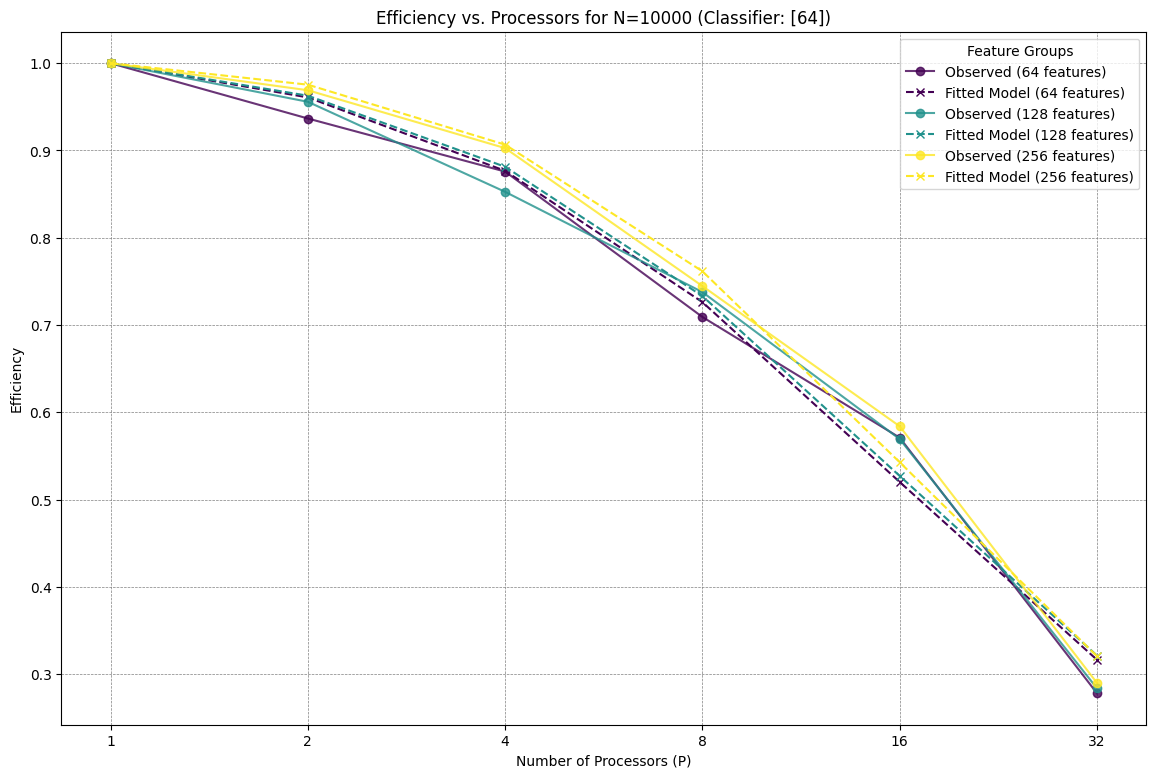

In [17]:
# Suponiendo que df_resultados_ex5_measures ya está cargado.
# Contiene columnas: 'n_samples', 'mlpclassifier', 'n_features', 'n_jobs', 'efficiency'.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
# IMPORTANTE: Asegúrate de que el valor coincida con el tipo de dato de tu columna.
# Si en tu DataFrame es un string '[64]', úsalo así. Si es un número, usa 64.
MLP_CLASSIFIER_TO_PLOT = [64] # O el valor que corresponda

# 2. Llama a la función con los tres argumentos
plot_efficiency_model_divided_features(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    MLP_CLASSIFIER_TO_PLOT
)

--- Modelo para n_features=64 ---
  (N_SAMPLES=200000, mlpclassifier='[256]')
  Componente Secuencial (C_s): -0.3315
  Componente Paralelizable (C_p): 22.6312
  Componente de Overhead (C_o): 0.4261



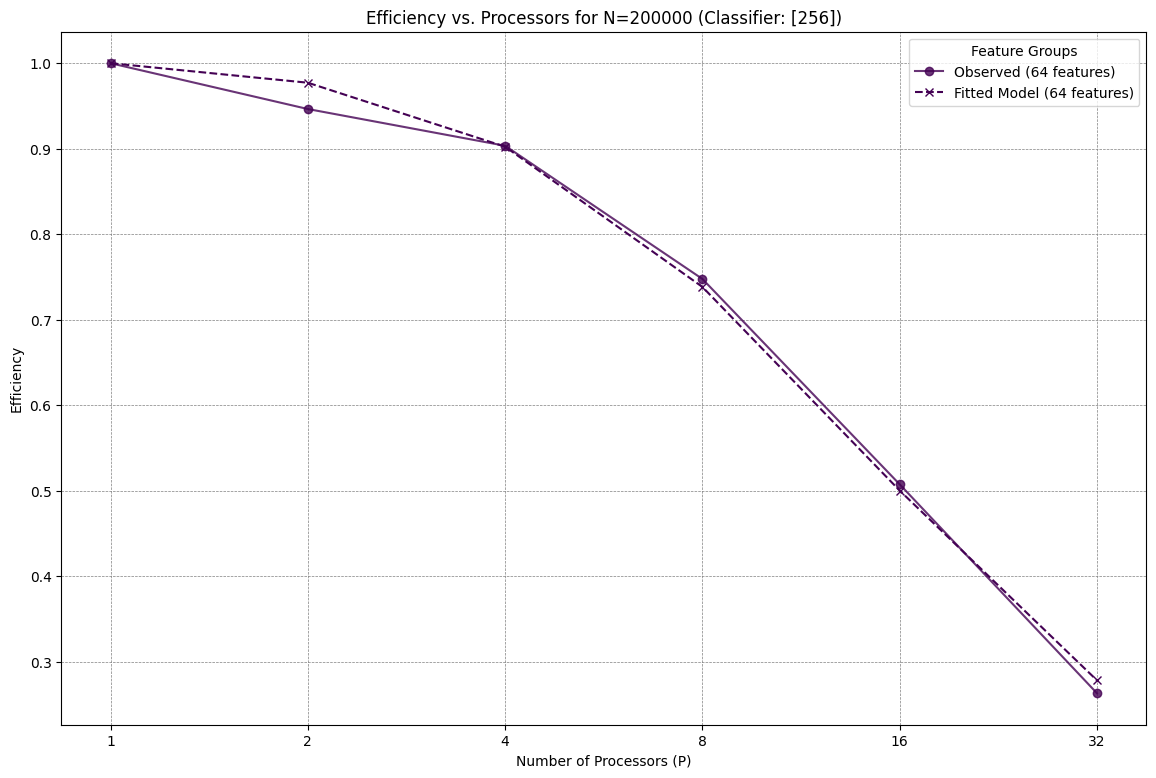

In [18]:
# Suponiendo que df_resultados_ex5_measures ya está cargado.
# Contiene columnas: 'n_samples', 'mlpclassifier', 'n_features', 'n_jobs', 'efficiency'.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 200000
# IMPORTANTE: Asegúrate de que el valor coincida con el tipo de dato de tu columna.
# Si en tu DataFrame es un string '[64]', úsalo así. Si es un número, usa 64.
MLP_CLASSIFIER_TO_PLOT = [256] # O el valor que corresponda

# 2. Llama a la función con los tres argumentos
plot_efficiency_model_divided_features(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    MLP_CLASSIFIER_TO_PLOT
)

--- Modelo para MLP = [64] ---
  (N_SAMPLES=10000, n_features=64)
  Componente Secuencial (C_s): 0.0420
  Componente Paralelizable (C_p): 1.8261
  Componente de Overhead (C_o): 0.0171

--- Modelo para MLP = [256] ---
  (N_SAMPLES=10000, n_features=64)
  Componente Secuencial (C_s): -0.0102
  Componente Paralelizable (C_p): 0.4049
  Componente de Overhead (C_o): 0.0082



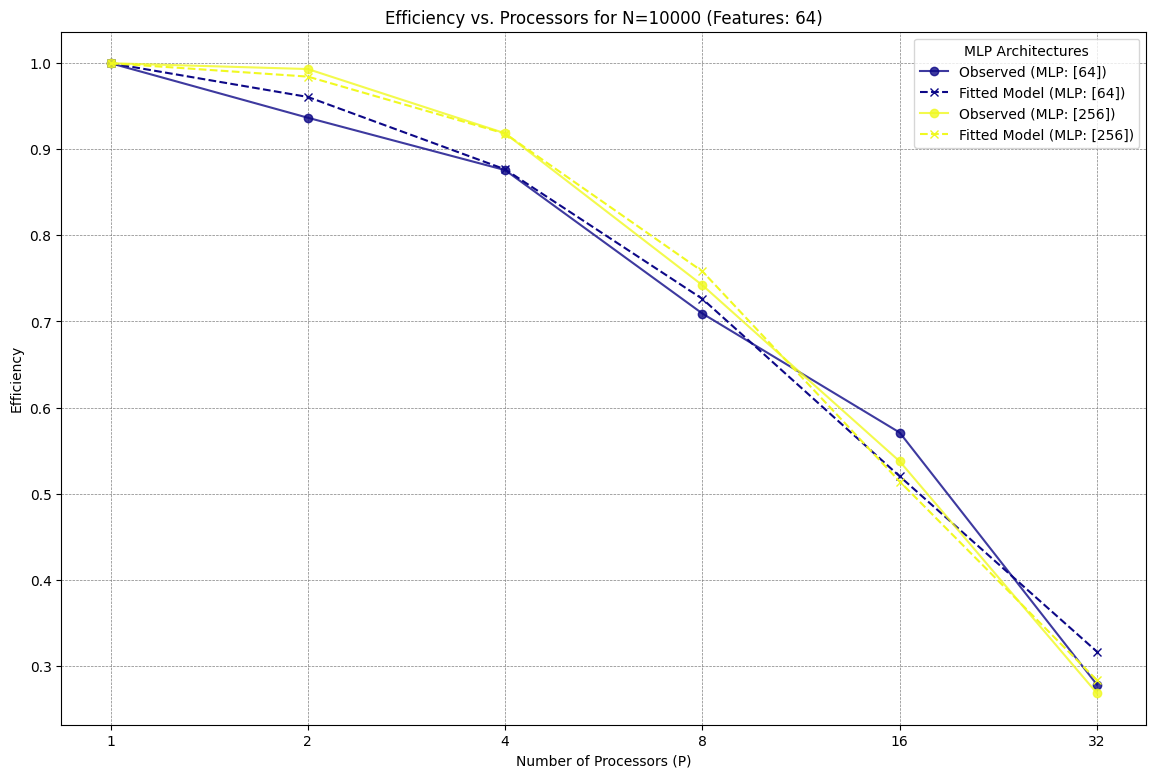

In [19]:
# Suponiendo que df_resultados_ex5_measures ya está cargado.
# Contiene columnas: 'n_samples', 'mlpclassifier__hidden_layer_sizes', 'n_features', etc.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
N_FEATURES_TO_PLOT = 64  # Por ejemplo, para analizar solo los casos con 64 features

# 2. Llama a la nueva función
plot_efficiency_model_divided_MLP(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

--- Modelo para MLP = [64] ---
  (N_SAMPLES=10000, n_features=256)
  Componente Secuencial (C_s): -0.0100
  Componente Paralelizable (C_p): 4.7514
  Componente de Overhead (C_o): 0.0648

--- Modelo para MLP = [256] ---
  (N_SAMPLES=10000, n_features=256)
  Componente Secuencial (C_s): -0.2026
  Componente Paralelizable (C_p): 7.0124
  Componente de Overhead (C_o): 0.1628



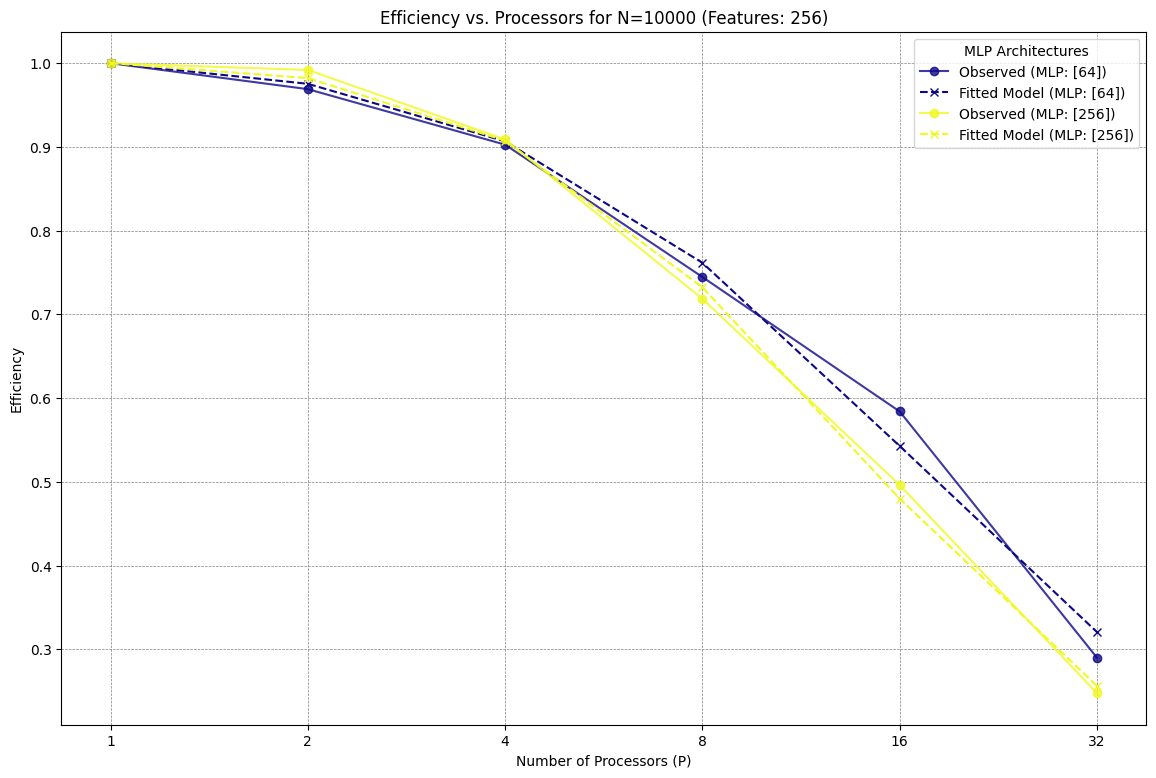

In [20]:
N_SAMPLES_TO_ANALYZE = 10000
N_FEATURES_TO_PLOT = 256  # Por ejemplo, para analizar solo los casos con 64 features

# 2. Llama a la nueva función
plot_efficiency_model_divided_MLP(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

In [21]:
def plot_speedup_divided_by_features(df_resultados, N_SAMPLES_TO_ANALYZE, MLP_CLASSIFIER_VALUE):
    """
    Filtra los datos por n_samples y mlpclassifier, y luego grafica el speedup
    para cada grupo de n_features encontrado.

    Args:
        df_resultados (pl.DataFrame): El DataFrame con los resultados.
        N_SAMPLES_TO_ANALYZE (int): El número de muestras a filtrar.
        MLP_CLASSIFIER_VALUE: El valor específico en la columna 'mlpclassifier' para filtrar.
    """
    # 1. Filtra el DataFrame por N_SAMPLES y el MLP_CLASSIFIER_VALUE
    # Asumo que la columna se llama 'mlpclassifier__hidden_layer_sizes' como en el ejemplo anterior.
    # Si tiene otro nombre, ajústalo aquí.
    df_filtered = df_resultados.filter(
        (pl.col("n_samples") == N_SAMPLES_TO_ANALYZE) &
        (pl.col("mlpclassifier__hidden_layer_sizes") == MLP_CLASSIFIER_VALUE)
    )

    if df_filtered.is_empty():
        print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE} y mlpclassifier = '{MLP_CLASSIFIER_VALUE}'.")
        return

    # 2. Obtiene los valores únicos de 'n_features' para crear una línea por cada uno
    n_features_groups = df_filtered.get_column("n_features").unique().sort().to_list()

    if not n_features_groups:
        print("No se encontraron grupos de 'n_features' para los filtros aplicados.")
        return

    # --- INICIO DE LA GRÁFICA ---
    plt.style.use('default')
    plt.figure(figsize=(12, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(n_features_groups)))

    # 3. Itera sobre cada grupo de n_features y plotea su línea de speedup
    for i, current_n_features in enumerate(n_features_groups):
        # Filtra el subset para el grupo actual
        subset = df_filtered.filter(pl.col("n_features") == current_n_features).sort("n_jobs")

        if not subset.is_empty():
            plt.plot(
                subset.get_column("n_jobs"),
                subset.get_column("speedup"),
                marker='o',
                linestyle='-',
                label=f'Speedup ({current_n_features} features)',
                color=colors[i]
            )

    # --- ESTILIZACIÓN DE LA GRÁFICA ---

    # 4. Añade la línea de "Speedup Ideal" para comparar
    all_n_jobs = df_filtered.get_column("n_jobs").unique().sort()
    plt.plot(
        all_n_jobs,
        all_n_jobs,
        linestyle='--',
        color='red',
        label='Speedup Ideal (Lineal)'
    )

    # 5. Configura etiquetas y título
    plt.xlabel("Número de Jobs (Procesos Paralelos)")
    plt.ylabel("Speedup (Log Scale)")
    plt.title(f"Análisis de Speedup para N={N_SAMPLES_TO_ANALYZE} (Classifier: {MLP_CLASSIFIER_VALUE})")

    # 6. Configura los ejes en escala logarítmica
    plt.xscale("log", base=2)
    plt.yscale("log", base=2) # Base 2 también es común para speedup
    plt.xticks(all_n_jobs, all_n_jobs)

    # 7. Añade leyenda y cuadrícula
    plt.legend(title="Grupos por n_features")
    plt.grid(True, which="both", ls="--", lw=0.5)

    # 8. Muestra la gráfica
    plt.show()

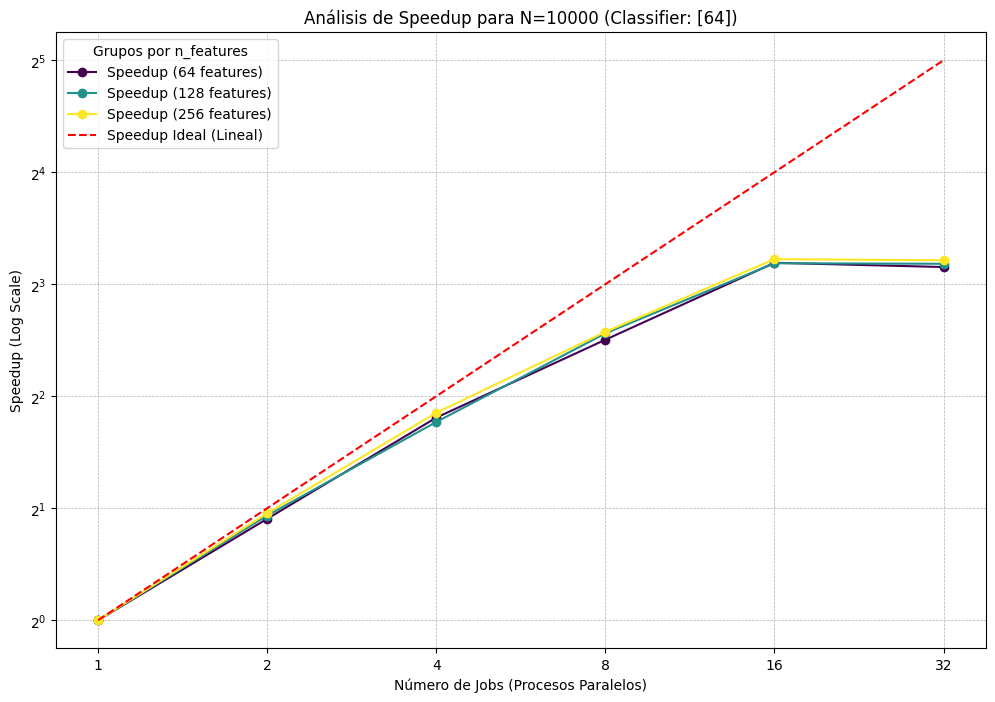

In [22]:
N_SAMPLES_TO_ANALYZE = 10000
MLP_CLASSIFIER_TO_PLOT = [64] # O el valor que desees analizar

# 2. Llama a la función para generar el gráfico
plot_speedup_divided_by_features(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    MLP_CLASSIFIER_TO_PLOT
)

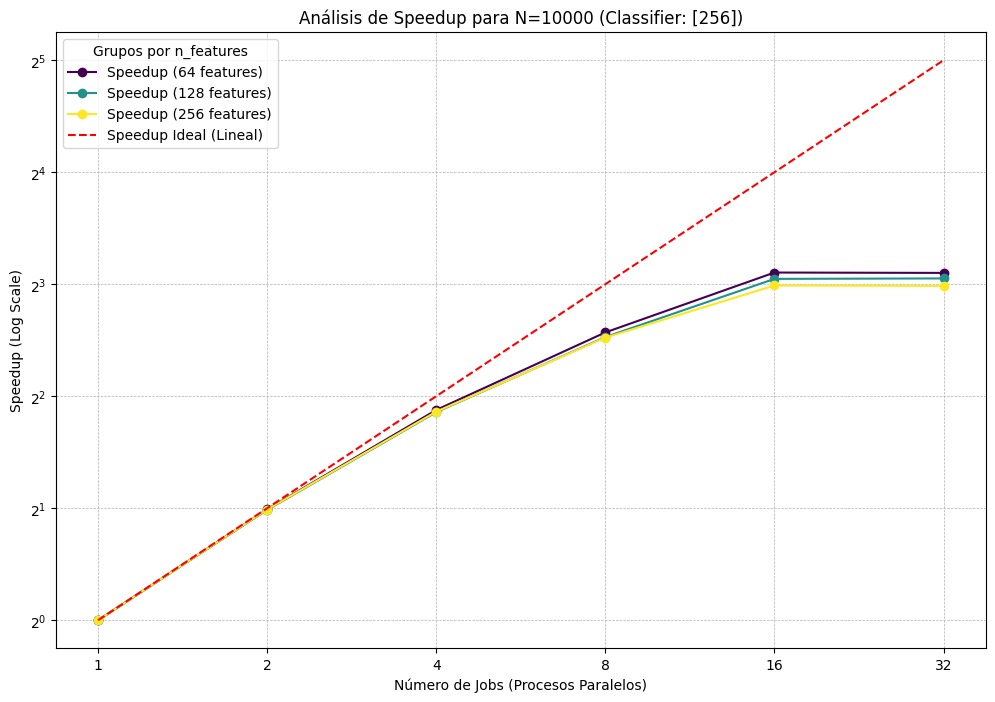

In [23]:
N_SAMPLES_TO_ANALYZE = 10000
MLP_CLASSIFIER_TO_PLOT = [256] # O el valor que desees analizar

# 2. Llama a la función para generar el gráfico
plot_speedup_divided_by_features(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    MLP_CLASSIFIER_TO_PLOT
)

In [24]:
def plot_speedup_divided_by_mlp(df_resultados, N_SAMPLES_TO_ANALYZE, N_FEATURES_VALUE):
    """
    Filtra los datos por n_samples y n_features, y luego grafica el speedup
    para cada arquitectura MLP encontrada.

    Args:
        df_resultados (pl.DataFrame): El DataFrame con los resultados.
        N_SAMPLES_TO_ANALYZE (int): El número de muestras a filtrar.
        N_FEATURES_VALUE (int): El número de features específico para filtrar.
    """
    # 1. Filtra el DataFrame por N_SAMPLES y el N_FEATURES_VALUE
    df_filtered = df_resultados.filter(
        (pl.col("n_samples") == N_SAMPLES_TO_ANALYZE) &
        (pl.col("n_features") == N_FEATURES_VALUE)
    )

    if df_filtered.is_empty():
        print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE} y n_features = {N_FEATURES_VALUE}.")
        return

    # 2. Obtiene los valores únicos de 'mlpclassifier__hidden_layer_sizes' para crear una línea por cada uno
    mlp_groups = df_filtered.get_column("mlpclassifier__hidden_layer_sizes").unique().sort().to_list()

    if not mlp_groups:
        print("No se encontraron arquitecturas MLP para los filtros aplicados.")
        return

    # --- INICIO DE LA GRÁFICA ---
    plt.style.use('default')
    plt.figure(figsize=(12, 8))

    # Usamos una paleta de colores diferente para distinguirla de la gráfica anterior
    colors = plt.cm.plasma(np.linspace(0, 1, len(mlp_groups)))

    # 3. Itera sobre cada arquitectura MLP y plotea su línea de speedup
    for i, current_mlp in enumerate(mlp_groups):
        # Filtra el subset para el grupo actual
        subset = df_filtered.filter(pl.col("mlpclassifier__hidden_layer_sizes") == current_mlp).sort("n_jobs")

        if not subset.is_empty():
            plt.plot(
                subset.get_column("n_jobs"),
                subset.get_column("speedup"),
                marker='o',
                linestyle='-',
                label=f'Speedup (MLP: {current_mlp})',
                color=colors[i]
            )

    # --- ESTILIZACIÓN DE LA GRÁFICA ---

    # 4. Añade la línea de "Speedup Ideal"
    all_n_jobs = df_filtered.get_column("n_jobs").unique().sort()
    plt.plot(
        all_n_jobs,
        all_n_jobs,
        linestyle='--',
        color='red',
        label='Speedup Ideal (Lineal)'
    )

    # 5. Configura etiquetas y título
    plt.xlabel("Número de Jobs (Procesos Paralelos)")
    plt.ylabel("Speedup (Log Scale)")
    plt.title(f"Análisis de Speedup para N={N_SAMPLES_TO_ANALYZE} (Features: {N_FEATURES_VALUE})")

    # 6. Configura los ejes en escala logarítmica
    plt.xscale("log", base=2)
    plt.yscale("log", base=2)
    plt.xticks(all_n_jobs, all_n_jobs)

    # 7. Añade leyenda y cuadrícula
    plt.legend(title="Arquitecturas MLP")
    plt.grid(True, which="both", ls="--", lw=0.5)

    # 8. Muestra la gráfica
    plt.show()

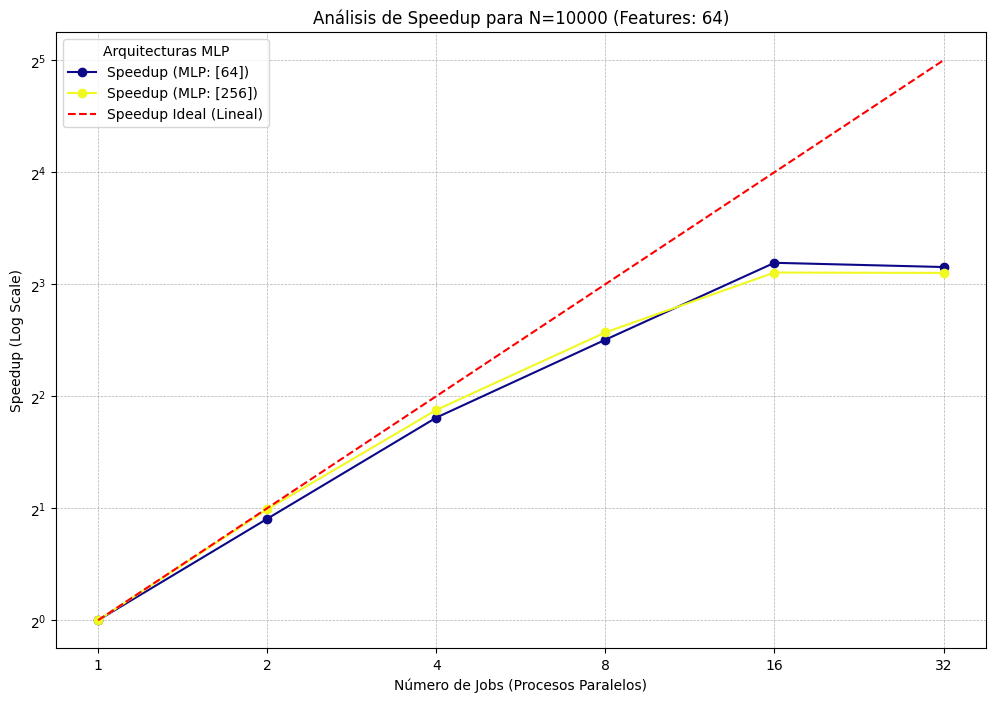

In [25]:
# Suponiendo que tu DataFrame 'df_resultados_ex5_measures' está disponible.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
N_FEATURES_TO_PLOT = 64  # Por ejemplo, para analizar solo los casos con 128 features

# 2. Llama a la función para generar el gráfico de speedup
plot_speedup_divided_by_mlp(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

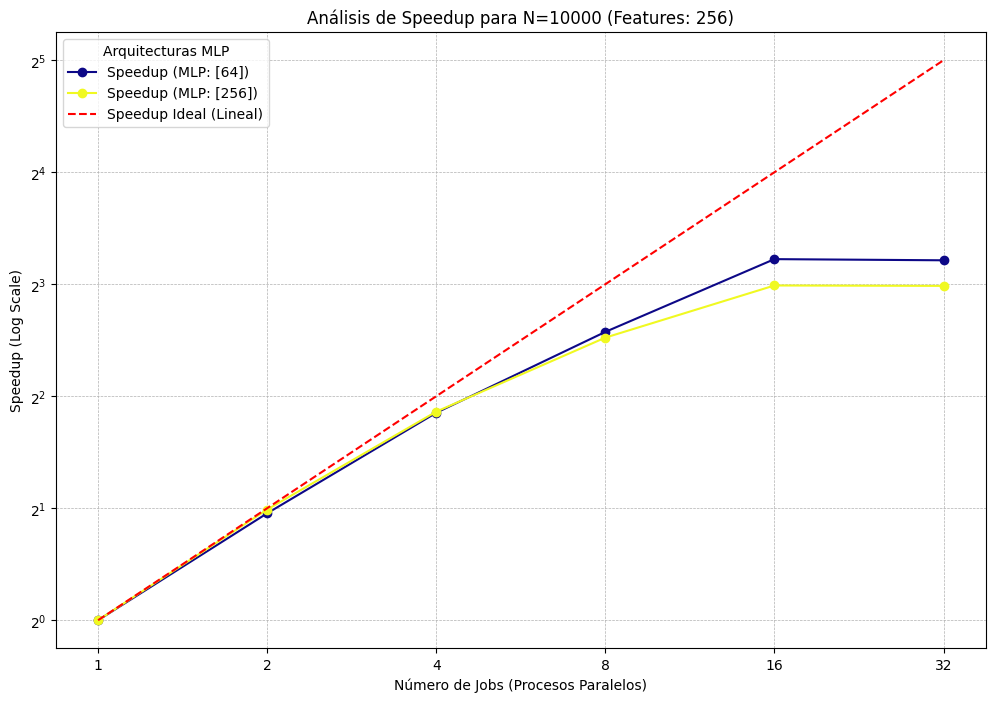

In [26]:
# Suponiendo que tu DataFrame 'df_resultados_ex5_measures' está disponible.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
N_FEATURES_TO_PLOT = 256  # Por ejemplo, para analizar solo los casos con 128 features

# 2. Llama a la función para generar el gráfico de speedup
plot_speedup_divided_by_mlp(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

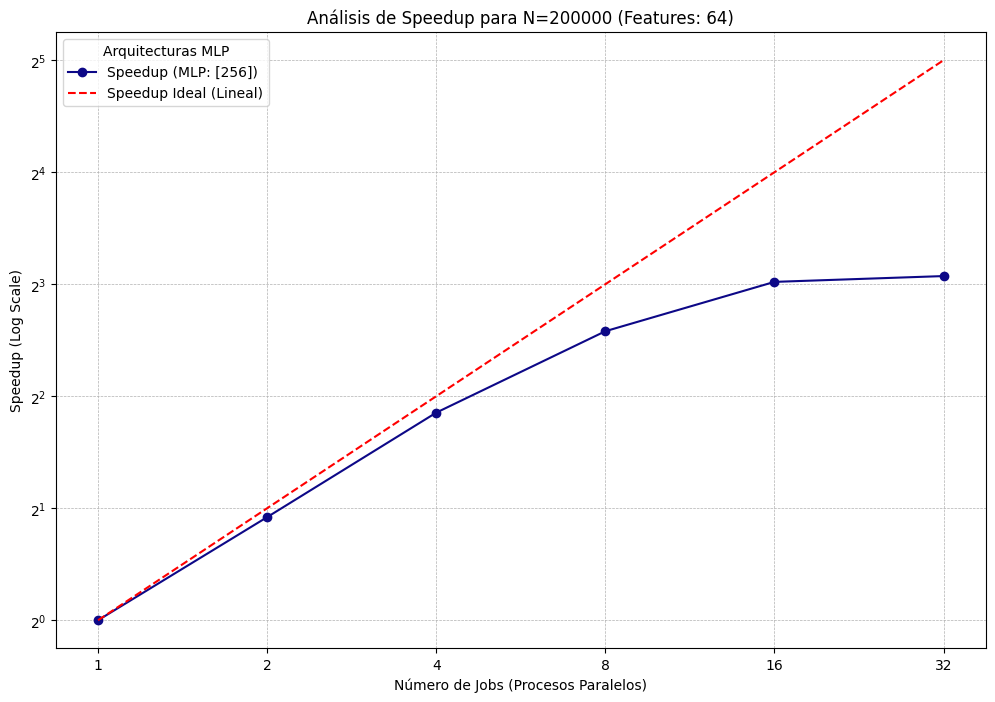

In [27]:
# Suponiendo que tu DataFrame 'df_resultados_ex5_measures' está disponible.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 200000
N_FEATURES_TO_PLOT = 64  # Por ejemplo, para analizar solo los casos con 128 features

# 2. Llama a la función para generar el gráfico de speedup
plot_speedup_divided_by_mlp(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

In [28]:
def plot_time_model_divided_by_features(df_resultados, N_SAMPLES_TO_ANALYZE, MLP_CLASSIFIER_VALUE):
    """
    Filtra los datos por n_samples y mlpclassifier, y luego grafica y modela el
    tiempo de ejecución para cada grupo de n_features encontrado.

    Args:
        df_resultados (pl.DataFrame): El DataFrame con los resultados.
        N_SAMPLES_TO_ANALYZE (int): El número de muestras a filtrar.
        MLP_CLASSIFIER_VALUE: El valor específico en 'mlpclassifier__hidden_layer_sizes' para filtrar.
    """
    # 1. Filtra el DataFrame por N_SAMPLES y el MLP_CLASSIFIER_VALUE
    df_filtered = df_resultados.filter(
        (pl.col("n_samples") == N_SAMPLES_TO_ANALYZE) &
        (pl.col("mlpclassifier__hidden_layer_sizes") == MLP_CLASSIFIER_VALUE)
    )

    if df_filtered.is_empty():
        print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE} y mlpclassifier = '{MLP_CLASSIFIER_VALUE}'.")
        return

    # 2. Obtiene los valores únicos de 'n_features' para crear una línea por cada uno
    n_features_groups = df_filtered.get_column("n_features").unique().sort().to_list()

    if not n_features_groups:
        print("No se encontraron grupos de 'n_features' para los filtros aplicados.")
        return

    # --- INICIO DE LA GRÁFICA ---
    plt.style.use('default')
    plt.figure(figsize=(12, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(n_features_groups)))

    # 3. Define la función del modelo teórico de tiempo
    def theoretical_time_model(p, C_s, C_p, C_o):
        """ Modelo de tiempo de ejecución con overhead. """
        # np.log2(p) devuelve NaN para p=0, pero aquí p >= 1.
        # Para p=1, el término de overhead es 0.
        return C_s + (C_p / p) + (C_o * np.log2(p + 1e-9)) # Epsilon para evitar log(0)

    # 4. Itera sobre cada grupo de n_features para modelar y graficar
    for i, current_n_features in enumerate(n_features_groups):

        df_single_group = df_filtered.filter(
            pl.col('n_features') == current_n_features
        ).sort("n_jobs")

        if df_single_group.is_empty():
            continue

        P = df_single_group.get_column("n_jobs").to_numpy()
        T_observed = df_single_group.get_column("tiempo_total_entrenamiento").to_numpy()

        # Plotea los datos medidos
        plt.plot(P, T_observed, marker='o', linestyle='-', label=f'Observed Time ({current_n_features} features)', color=colors[i], alpha=0.8)

        # Ajusta el modelo
        try:
            # Usar los valores del primer punto como guía para p0 puede ayudar
            p0_guess = [T_observed[-1], T_observed[0], 0.1]
            p_opt, _ = curve_fit(theoretical_time_model, P, T_observed, p0=p0_guess, maxfev=5000)
            C_s_fit, C_p_fit, C_o_fit = p_opt

            T_fitted = theoretical_time_model(P, C_s_fit, C_p_fit, C_o_fit)

            print(f"--- Modelo para n_features={current_n_features} ---")
            print(f"  (N_SAMPLES={N_SAMPLES_TO_ANALYZE}, mlpclassifier='{MLP_CLASSIFIER_VALUE}')")
            print(f"  Componente Secuencial (C_s): {C_s_fit:.3f} s")
            print(f"  Componente Paralelizable (C_p): {C_p_fit:.3f} s")
            print(f"  Componente de Overhead (C_o): {C_o_fit:.3f} s\n")

            # Plotea el modelo ajustado
            plt.plot(P, T_fitted, marker='x', linestyle='--', label=f'Fitted Model ({current_n_features} features)', color=colors[i])

        except RuntimeError:
            print(f"El ajuste del modelo de tiempo falló para n_features={current_n_features}.\n")

    # --- ESTILIZACIÓN FINAL DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Time (seconds)")
    plt.title(f"Execution Time vs. Processors for N={N_SAMPLES_TO_ANALYZE} (Classifier: {MLP_CLASSIFIER_VALUE})")

    plt.xscale("log", base=2)
    all_p_values = df_filtered.get_column("n_jobs").unique().sort().to_list()
    plt.xticks(all_p_values, all_p_values)

    plt.legend(title="Feature Groups")
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

--- Modelo para n_features=64 ---
  (N_SAMPLES=10000, mlpclassifier='[64]')
  Componente Secuencial (C_s): 2.439 s
  Componente Paralelizable (C_p): 96.714 s
  Componente de Overhead (C_o): 0.932 s

--- Modelo para n_features=128 ---
  (N_SAMPLES=10000, mlpclassifier='[64]')
  Componente Secuencial (C_s): 2.469 s
  Componente Paralelizable (C_p): 114.424 s
  Componente de Overhead (C_o): 1.154 s

--- Modelo para n_features=256 ---
  (N_SAMPLES=10000, mlpclassifier='[64]')
  Componente Secuencial (C_s): -0.817 s
  Componente Paralelizable (C_p): 152.763 s
  Componente de Overhead (C_o): 2.284 s



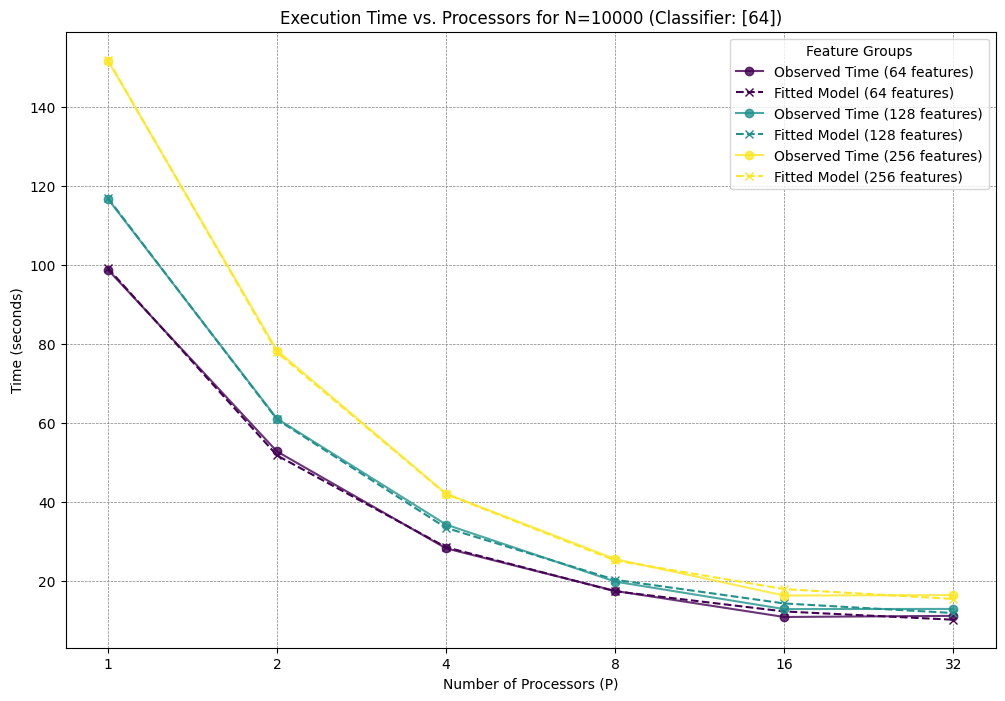

In [29]:
# Suponiendo que tu DataFrame 'df_resultados_ex5_measures' está disponible y tiene la
# columna 'tiempo_total_entrenamiento'.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
MLP_CLASSIFIER_TO_PLOT = [64] # Elige la arquitectura que quieres aislar

# 2. Llama a la función para generar el gráfico
plot_time_model_divided_by_features(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    MLP_CLASSIFIER_TO_PLOT
)

--- Modelo para n_features=64 ---
  (N_SAMPLES=200000, mlpclassifier='[256]')
  Componente Secuencial (C_s): -78.144 s
  Componente Paralelizable (C_p): 10184.813 s
  Componente de Overhead (C_o): 180.080 s



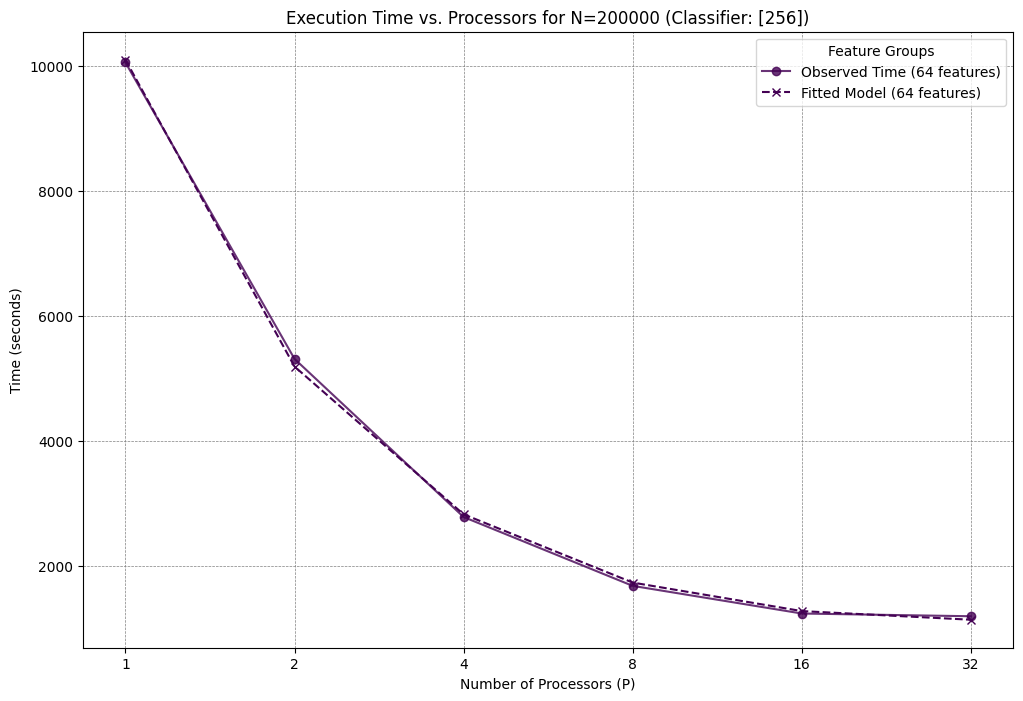

In [30]:
# Suponiendo que tu DataFrame 'df_resultados_ex5_measures' está disponible y tiene la
# columna 'tiempo_total_entrenamiento'.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 200000
MLP_CLASSIFIER_TO_PLOT = [256] # Elige la arquitectura que quieres aislar

# 2. Llama a la función para generar el gráfico
plot_time_model_divided_by_features(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    MLP_CLASSIFIER_TO_PLOT
)

In [31]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def plot_time_model_divided_by_mlp(df_resultados, N_SAMPLES_TO_ANALYZE, N_FEATURES_VALUE):
    """
    Filtra los datos por n_samples y n_features, y luego grafica y modela el
    tiempo de ejecución para cada arquitectura MLP encontrada.

    Args:
        df_resultados (pl.DataFrame): El DataFrame con los resultados.
        N_SAMPLES_TO_ANALYZE (int): El número de muestras a filtrar.
        N_FEATURES_VALUE (int): El número de features específico para filtrar.
    """
    # 1. Filtra el DataFrame por N_SAMPLES y el N_FEATURES_VALUE
    df_filtered = df_resultados.filter(
        (pl.col("n_samples") == N_SAMPLES_TO_ANALYZE) &
        (pl.col("n_features") == N_FEATURES_VALUE)
    )

    if df_filtered.is_empty():
        print(f"No se encontraron datos para N_SAMPLES = {N_SAMPLES_TO_ANALYZE} y n_features = {N_FEATURES_VALUE}.")
        return

    # 2. Obtiene los valores únicos de 'mlpclassifier__hidden_layer_sizes' para agrupar
    mlp_groups = df_filtered.get_column("mlpclassifier__hidden_layer_sizes").unique().sort().to_list()

    if not mlp_groups:
        print("No se encontraron arquitecturas MLP para los filtros aplicados.")
        return

    # --- INICIO DE LA GRÁFICA ---
    plt.style.use('default')
    plt.figure(figsize=(12, 8))

    colors = plt.cm.plasma(np.linspace(0, 1, len(mlp_groups)))

    # 3. Define la función del modelo teórico de tiempo
    def theoretical_time_model(p, C_s, C_p, C_o):
        """ Modelo de tiempo de ejecución con overhead. """
        return C_s + (C_p / p) + (C_o * np.log2(p + 1e-9))

    # 4. Itera sobre cada arquitectura MLP para modelar y graficar
    for i, current_mlp in enumerate(mlp_groups):

        df_single_group = df_filtered.filter(
            pl.col('mlpclassifier__hidden_layer_sizes') == current_mlp
        ).sort("n_jobs")

        if df_single_group.is_empty():
            continue

        P = df_single_group.get_column("n_jobs").to_numpy()
        T_observed = df_single_group.get_column("tiempo_total_entrenamiento").to_numpy()

        # Plotea los datos medidos
        plt.plot(P, T_observed, marker='o', linestyle='-', label=f'Observed Time (MLP: {current_mlp})', color=colors[i], alpha=0.8)

        # Ajusta el modelo
        try:
            p0_guess = [T_observed[-1], T_observed[0], 0.1]
            p_opt, _ = curve_fit(theoretical_time_model, P, T_observed, p0=p0_guess, maxfev=5000)
            C_s_fit, C_p_fit, C_o_fit = p_opt

            T_fitted = theoretical_time_model(P, C_s_fit, C_p_fit, C_o_fit)

            print(f"--- Modelo para MLP = {current_mlp} ---")
            print(f"  (N_SAMPLES={N_SAMPLES_TO_ANALYZE}, n_features={N_FEATURES_VALUE})")
            print(f"  Componente Secuencial (C_s): {C_s_fit:.3f} s")
            print(f"  Componente Paralelizable (C_p): {C_p_fit:.3f} s")
            print(f"  Componente de Overhead (C_o): {C_o_fit:.3f} s\n")

            # Plotea el modelo ajustado
            plt.plot(P, T_fitted, marker='x', linestyle='--', label=f'Fitted Model (MLP: {current_mlp})', color=colors[i])

        except RuntimeError:
            print(f"El ajuste del modelo de tiempo falló para MLP={current_mlp}.\n")

    # --- ESTILIZACIÓN FINAL DE LA GRÁFICA ---
    plt.xlabel("Number of Processors (P)")
    plt.ylabel("Time (seconds)")
    plt.title(f"Execution Time vs. Processors for N={N_SAMPLES_TO_ANALYZE} (Features: {N_FEATURES_VALUE})")

    plt.xscale("log", base=2)
    all_p_values = df_filtered.get_column("n_jobs").unique().sort().to_list()
    plt.xticks(all_p_values, all_p_values)

    plt.legend(title="MLP Architectures")
    plt.grid(True, which="both", ls="--", lw=0.5, color='gray')

    plt.show()

--- Modelo para MLP = [64] ---
  (N_SAMPLES=10000, n_features=64)
  Componente Secuencial (C_s): 2.439 s
  Componente Paralelizable (C_p): 96.714 s
  Componente de Overhead (C_o): 0.932 s

--- Modelo para MLP = [256] ---
  (N_SAMPLES=10000, n_features=64)
  Componente Secuencial (C_s): -13.080 s
  Componente Paralelizable (C_p): 394.294 s
  Componente de Overhead (C_o): 8.835 s



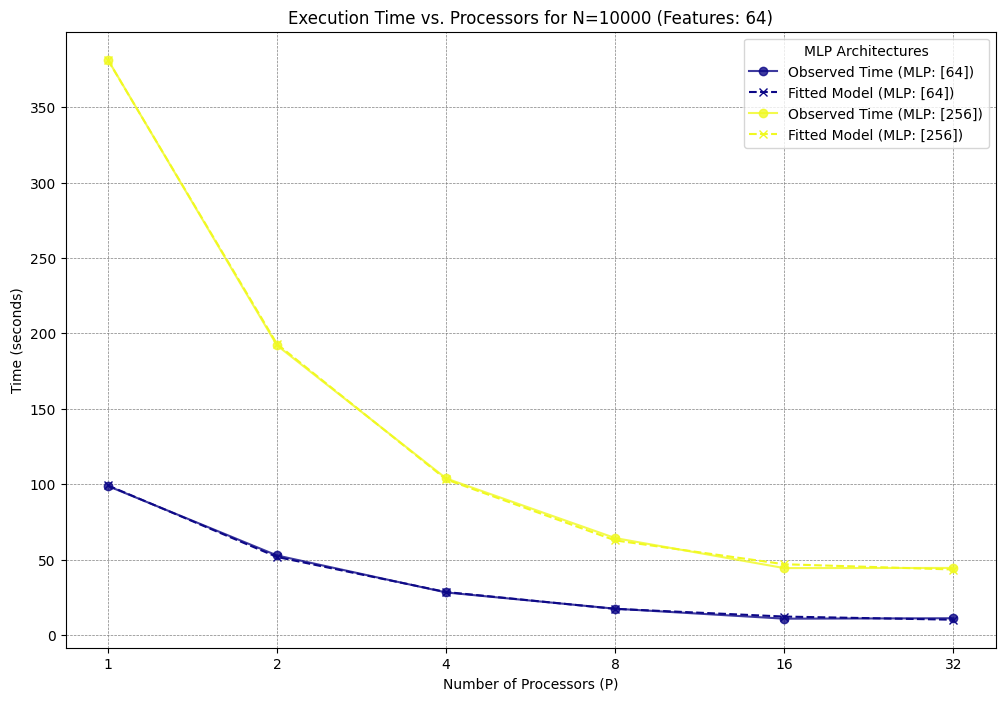

In [32]:
# Suponiendo que 'df_resultados_ex5_measures' está cargado.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
N_FEATURES_TO_PLOT = 64  # Elige el número de features que quieres aislar

# 2. Llama a la función para generar el gráfico de tiempo
plot_time_model_divided_by_mlp(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

--- Modelo para MLP = [64] ---
  (N_SAMPLES=10000, n_features=256)
  Componente Secuencial (C_s): -0.817 s
  Componente Paralelizable (C_p): 152.763 s
  Componente de Overhead (C_o): 2.284 s

--- Modelo para MLP = [256] ---
  (N_SAMPLES=10000, n_features=256)
  Componente Secuencial (C_s): -19.541 s
  Componente Paralelizable (C_p): 542.875 s
  Componente de Overhead (C_o): 13.568 s



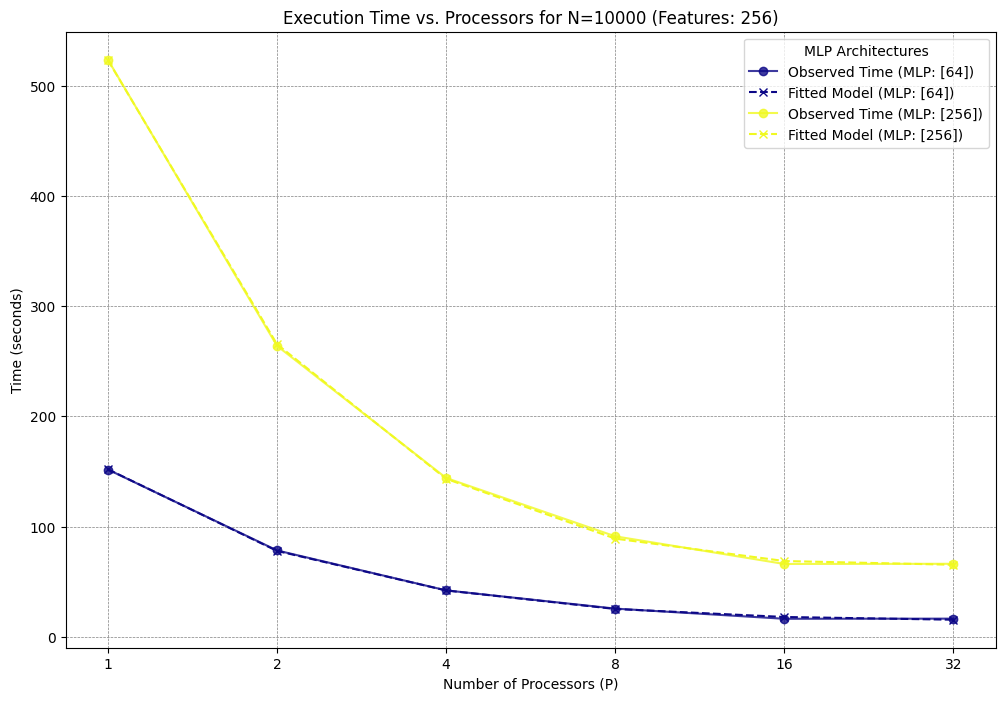

In [33]:
# Suponiendo que 'df_resultados_ex5_measures' está cargado.

# 1. Define los parámetros para el filtro
N_SAMPLES_TO_ANALYZE = 10000
N_FEATURES_TO_PLOT = 256  # Elige el número de features que quieres aislar

# 2. Llama a la función para generar el gráfico de tiempo
plot_time_model_divided_by_mlp(
    df_resultados_ex5_measures,
    N_SAMPLES_TO_ANALYZE,
    N_FEATURES_TO_PLOT
)

In [34]:
base_path_ex5 = Path('logs/run_ex5')
file_glob_ex5 = 'rnn_rnn_joblib_ex5_1*.out'
df_resultados_ex5 = procesar_y_expandir_logs(ruta_busqueda=base_path_ex5.joinpath(file_glob_ex5).as_posix()).filter(pl.col('tiempo_total_entrenamiento').is_not_null())
df_resultados_ex5_measures_filter_only = df_resultados_ex5.with_columns(
    pl.col('tiempo_total_entrenamiento').filter(pl.col('n_jobs') == 1).first().over('n_samples', 'mlpclassifier__hidden_layer_sizes','n_features').alias(
        'numerador_speedup')).with_columns(
    speedup=pl.col('numerador_speedup') / pl.col('tiempo_total_entrenamiento')).with_columns(
    efficiency=pl.col('speedup') / pl.col('n_jobs'),speedup_pct_change=pl.col('speedup').pct_change().over('n_samples',order_by='n_jobs')).sort(by=['n_samples','n_jobs']).filter(pl.col('n_samples')!=200000)

Procesando 67 archivo(s)...


In [35]:
df_resultados_ex5_measures_filter_only

archivo,n_jobs,n_samples,slurm_cpus_per_task,inner_n_jobs,tiempo_total_entrenamiento,n_features,mlpclassifier__alpha,mlpclassifier__hidden_layer_sizes,mlpclassifier__learning_rate_init,numerador_speedup,speedup,efficiency,speedup_pct_change
str,i64,i64,i64,i64,f64,i64,f64,list[i64],f64,f64,f64,f64,f64
"""rnn_rnn_joblib_ex5_16658_24.ou…",1,5000,32,1,213.273,128,0.0001,[256],0.001,213.273,1.0,1.0,0.0
"""rnn_rnn_joblib_ex5_16658_0.out""",1,5000,32,1,193.095,64,0.0001,[256],0.001,193.095,1.0,1.0,null
"""rnn_rnn_joblib_ex5_16658_1.out""",2,5000,32,1,97.838,64,0.0001,[256],0.001,193.095,1.97362,0.98681,0.97362
"""rnn_rnn_joblib_ex5_16658_25.ou…",2,5000,32,1,110.066,128,0.0001,[256],0.001,213.273,1.937683,0.968841,-0.018209
"""rnn_rnn_joblib_ex5_16658_2.out""",4,5000,32,1,53.212,64,0.0001,[256],0.001,193.095,3.628787,0.907197,0.872745
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""rnn_rnn_joblib_ex5_16658_13.ou…",2,40000,32,1,758.451,64,0.0001,[256],0.001,1499.105,1.976535,0.988268,0.976535
"""rnn_rnn_joblib_ex5_16658_14.ou…",4,40000,32,1,402.079,64,0.0001,[256],0.001,1499.105,3.728384,0.932096,0.886323
"""rnn_rnn_joblib_ex5_16658_15.ou…",8,40000,32,1,254.781,64,0.0001,[256],0.001,1499.105,5.883896,0.735487,0.578136
